In [5]:
# Core imports
import os, json, pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
# Dataset path
dataset_path = r"C:\Users\Waliur\OneDrive\Documents\Codes\python\Projects\AgroVision\PlantVillage"

print("Dataset path set successfully:", dataset_path)

Dataset path set successfully: C:\Users\Waliur\OneDrive\Documents\Codes\python\Projects\AgroVision\PlantVillage


In [7]:
# Data generators with strong augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42
)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


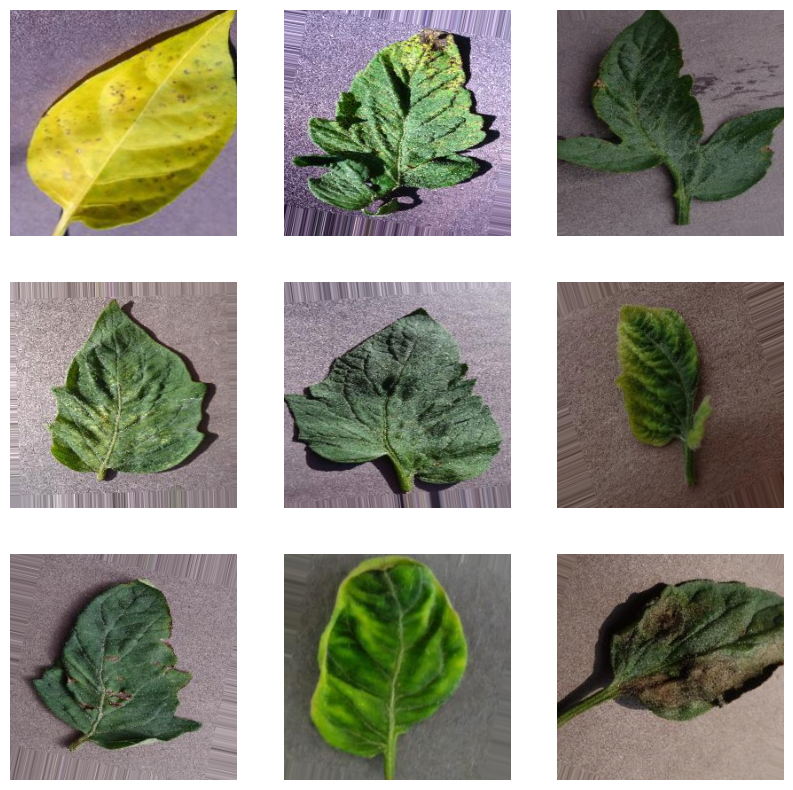

In [8]:
# Preview batch
x_batch, y_batch = next(train_data)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()

In [5]:
# Compute balanced class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))
for k in class_weights:
    class_weights[k] = min(class_weights[k], 5.0)  # cap extreme weights

# Build model: full MobileNetV2 fine-tuning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = True  # 🔓 Unfreeze all layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(train_data.num_classes, activation='softmax')
])

# Compile with AdamW + label smoothing
optimizer = tf.keras.optimizers.AdamW(learning_rate=5e-5, weight_decay=1e-5)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
checkpoint = ModelCheckpoint("best_agrovision_model.keras", monitor="val_accuracy", save_best_only=True)

# Train (single stage)
# Train (single stage)
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,   # ⬅️ shortened for faster training
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights
)


C:\Users\Waliur\AppData\Local\Temp\ipykernel_25764\3011388026.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


Epoch 1/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 1044s 2s/step - accuracy: 0.6463 - loss: 1.4559 - val_accuracy: 0.4571 - val_loss: 1.9749 - learning_rate: 5.0000e-05
Epoch 2/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 998s 2s/step - accuracy: 0.8940 - loss: 0.8757 - val_accuracy: 0.6431 - val_loss: 1.4655 - learning_rate: 5.0000e-05
Epoch 3/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 998s 2s/step - accuracy: 0.9362 - loss: 0.7765 - val_accuracy: 0.7630 - val_loss: 1.1578 - learning_rate: 5.0000e-05
Epoch 4/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 998s 2s/step - accuracy: 0.9582 - loss: 0.7196 - val_accuracy: 0.8367 - val_loss: 0.9988 - learning_rate: 5.0000e-05
Epoch 5/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 997s 2s/step - accuracy: 0.9678 - loss: 0.6929 - val_accuracy: 0.8935 - val_loss: 0.8728 - learning_rate: 5.0000e-05
Epoch 6/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 994s 2s/step - accuracy: 0.9746 - loss: 0.6687 - val_accuracy: 0.9602 - val_loss: 0.7086 - learning_rate: 5.0000e-05
Epoch 7/15
517/517 ━━━━━━━━━━━━━━━━━━━━ 995s 2s/step - ac

In [ ]:
# Save best model weights
model.save("best_agrovision_model.keras")

# Save class label mapping
with open("class_indices.json", "w") as f:
    json.dump(train_data.class_indices, f)

# Save training history
with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)


In [ ]:
# Evaluate best model
best_model = load_model("best_agrovision_model.keras")
val_loss, val_acc = best_model.evaluate(val_data)
print(f"Validation Accuracy (Best Model): {val_acc*100:.2f}%")

Found 4122 images belonging to 15 classes.
Predicting...
129/129 ━━━━━━━━━━━━━━━━━━━━ 53s 400ms/step


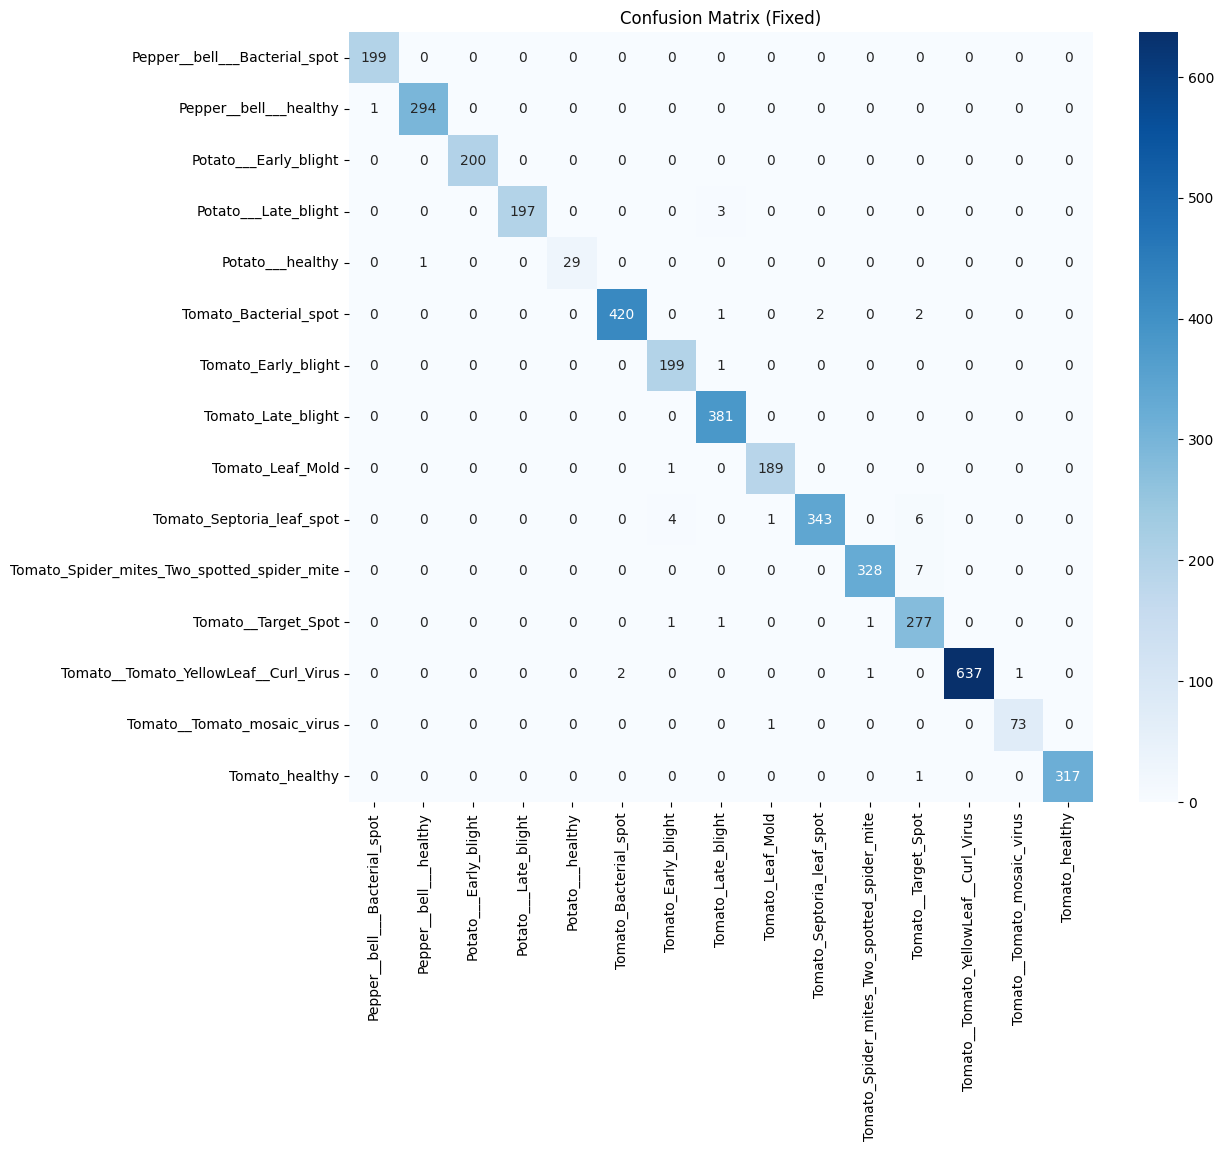

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      1.00      1.00       199
                     Pepper__bell___healthy       1.00      1.00      1.00       295
                      Potato___Early_blight       1.00      1.00      1.00       200
                       Potato___Late_blight       1.00      0.98      0.99       200
                           Potato___healthy       1.00      0.97      0.98        30
                      Tomato_Bacterial_spot       1.00      0.99      0.99       425
                        Tomato_Early_blight       0.97      0.99      0.98       200
                         Tomato_Late_blight       0.98      1.00      0.99       381
                           Tomato_Leaf_Mold       0.99      0.99      0.99       190
                  Tomato_Septoria_leaf_spot       0.99      0.97      0.98       354
Tomato_Spider_mites_Two_spotted_spider_mite       0.99      0.98

In [6]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Setup path again
dataset_path = r"C:\Users\Waliur\OneDrive\Documents\Codes\python\Projects\AgroVision\PlantVillage"

# 2. Create a CLEAN validation generator (No augmentation)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_data = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # <--- THIS IS THE KEY FIX
)

# 3. Load your EXISTING model
model = load_model("best_agrovision_model.keras")

# 4. Predict
print("Predicting...")
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes

# 5. Plot Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_data.class_indices.keys(),
            yticklabels=val_data.class_indices.keys())
plt.xticks(rotation=90)
plt.title('Confusion Matrix (Fixed)')
plt.show()

# 6. Print Report
print(classification_report(y_true, y_pred_classes, target_names=val_data.class_indices.keys()))

In [7]:
import pickle

# Load saved training history
with open("training_history.pkl", "rb") as f:
    history_data = pickle.load(f)


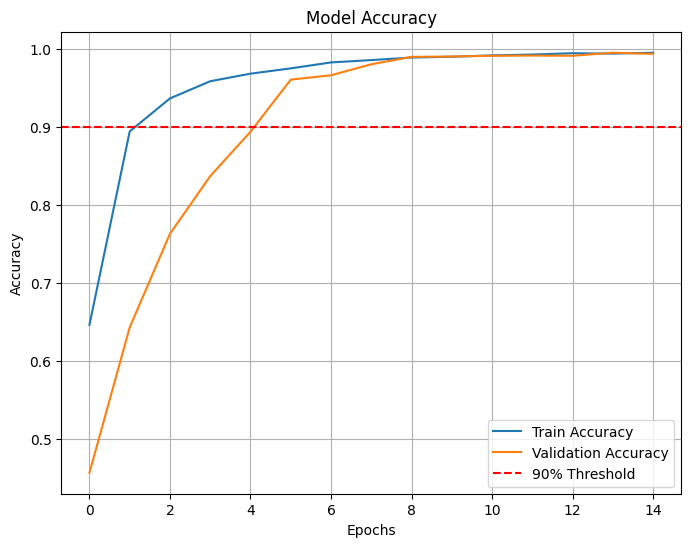

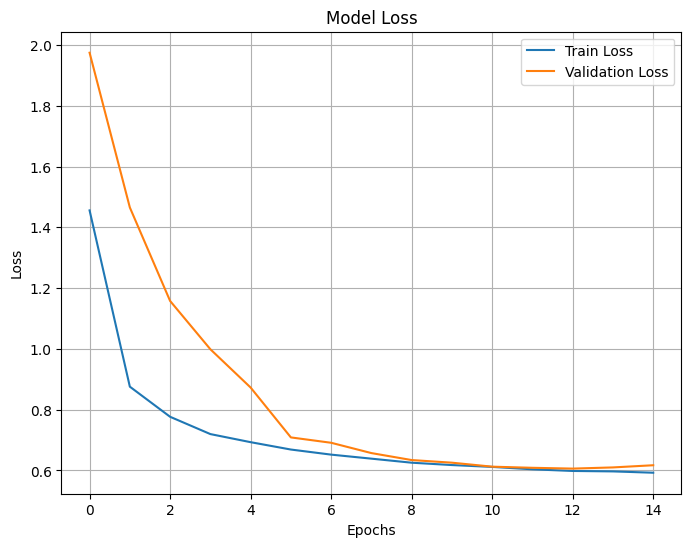

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(history_data['accuracy'], label='Train Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.axhline(0.90, color='red', linestyle='--', label='90% Threshold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("accuracy_curve.png", dpi=300)
plt.show()


plt.figure(figsize=(8,6))
plt.plot(history_data['loss'], label='Train Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig("loss_curve.png", dpi=300)
plt.show()

